In [1]:
# Baseline pipeline: preprocessing + RandomForest + log-target transform
import os, pandas as pd, numpy as np, joblib
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.compose import TransformedTargetRegressor

DATA_PROCESSED = os.path.join("..","data","processed")
df = pd.read_csv(os.path.join(DATA_PROCESSED, "train_final.csv"))

X = df.drop(columns=["SalePrice"])
y = df["SalePrice"].values

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="None")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
], remainder="drop")

rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)

pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", rf)
])

ttr = TransformedTargetRegressor(regressor=pipe, func=np.log1p, inverse_func=np.expm1)

# 5-fold CV RMSE
scores = -cross_val_score(ttr, X, y, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)
print(f"5-fold CV RMSE: mean={scores.mean():.2f}, std={scores.std():.2f}")

# Fit on full data and save
ttr.fit(X, y)
os.makedirs("models", exist_ok=True)
joblib.dump(ttr, "models/pipeline_v1.joblib")
print("Saved models/pipeline_v1.joblib")


5-fold CV RMSE: mean=25948.97, std=2178.86
Saved models/pipeline_v1.joblib


In [2]:
# Lasso Regression pipeline
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.001, random_state=42, max_iter=10000)

pipe_lasso = Pipeline([
    ("preprocessor", preprocessor),  # reuse same preprocessor
    ("model", lasso)
])

ttr_lasso = TransformedTargetRegressor(regressor=pipe_lasso, func=np.log1p, inverse_func=np.expm1)

scores_lasso = -cross_val_score(ttr_lasso, X, y, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)
print(f"Lasso CV RMSE: mean={scores_lasso.mean():.2f}, std={scores_lasso.std():.2f}")

ttr_lasso.fit(X, y)
joblib.dump(ttr_lasso, "models/pipeline_lasso.joblib")
print("Saved models/pipeline_lasso.joblib")


Lasso CV RMSE: mean=20400.76, std=1161.05
Saved models/pipeline_lasso.joblib


In [3]:
# Ridge Regression pipeline
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=10.0, random_state=42)

pipe_ridge = Pipeline([
    ("preprocessor", preprocessor),  # reuse same preprocessor
    ("model", ridge)
])

ttr_ridge = TransformedTargetRegressor(regressor=pipe_ridge, func=np.log1p, inverse_func=np.expm1)

# 5-fold CV RMSE
scores_ridge = -cross_val_score(ttr_ridge, X, y, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)
print(f"Ridge CV RMSE: mean={scores_ridge.mean():.2f}, std={scores_ridge.std():.2f}")

# Fit and save
ttr_ridge.fit(X, y)
joblib.dump(ttr_ridge, "models/pipeline_ridge.joblib")
print("Saved models/pipeline_ridge.joblib")


Ridge CV RMSE: mean=20535.68, std=1309.92
Saved models/pipeline_ridge.joblib


In [4]:
# LightGBM pipeline
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

pipe_lgbm = Pipeline([
    ("preprocessor", preprocessor),  # reuse same preprocessor
    ("model", lgbm)
])

ttr_lgbm = TransformedTargetRegressor(regressor=pipe_lgbm, func=np.log1p, inverse_func=np.expm1)

scores_lgbm = -cross_val_score(ttr_lgbm, X, y, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)
print(f"LightGBM CV RMSE: mean={scores_lgbm.mean():.2f}, std={scores_lgbm.std():.2f}")

ttr_lgbm.fit(X, y)
joblib.dump(ttr_lgbm, "models/pipeline_lgbm.joblib")
print("Saved models/pipeline_lgbm.joblib")


LightGBM CV RMSE: mean=22834.82, std=1734.38
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3978
[LightGBM] [Info] Number of data points in the train set: 1456, number of used features: 167
[LightGBM] [Info] Start training from score 12.021950
Saved models/pipeline_lgbm.joblib


,CV_RMSE
Lasso,20400.76
Ridge,20535.68
LightGBM,22834.82
RandomForest,25948.97


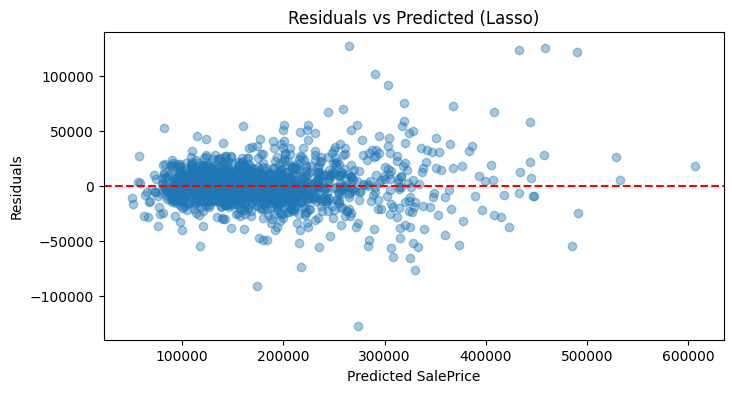

In [5]:
import matplotlib.pyplot as plt

# Gather CV results
results = {
    "RandomForest": 25948.97,  # replace with your actual CV mean
    "Ridge": 20535.68,
    "Lasso": 20400.76,
    "LightGBM": 22834.82
}
df_results = pd.DataFrame.from_dict(results, orient="index", columns=["CV_RMSE"])
df_results.sort_values("CV_RMSE", inplace=True)
display(df_results)

# Save for record
df_results.to_csv("models/model_comparison.csv")

# Plot residuals for champion (Lasso)
y_pred = ttr_lasso.predict(X)
residuals = y - y_pred

plt.figure(figsize=(8,4))
plt.scatter(y_pred, residuals, alpha=0.4)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted SalePrice")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted (Lasso)")
plt.show()
